In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from zarr_utils import ZarrReader
import numpy as np

In [10]:
cells = ZarrReader('cells.zarr.zip')
cell_feature_matrix = ZarrReader('cell_feature_matrix.zarr.zip')
transcripts = ZarrReader('transcripts.zarr.zip')
analysis = ZarrReader('analysis.zarr.zip')

The description of all of these zarr files can be found in following webpage: https://www.10xgenomics.com/support/software/xenium-onboard-analysis/latest/advanced/xoa-output-zarr#cells

In [16]:
a = [cells, cell_feature_matrix, transcripts, analysis]
for item in a:
    print(item.get_group().tree())

/
 ├── cell_id (162628, 2) uint32
 ├── cell_summary (162628, 7) float64
 ├── masks
 │   ├── 0 (20528, 42618) uint32
 │   ├── 1 (20528, 42618) uint32
 │   └── homogeneous_transform (4, 4) float32
 ├── polygon_num_vertices (2, 162628) int32
 ├── polygon_vertices (2, 162628, 26) float32
 └── seg_mask_value (162628,) uint32
/
 └── cell_features
     ├── cell_id (162628, 2) uint32
     ├── data (9934340,) uint32
     ├── indices (9934340,) uint32
     └── indptr (540,) uint32
/
 ├── codeword_category (541, 7) bool
 ├── density
 │   └── gene
 │       ├── data (11706597,) uint16
 │       ├── indices (11706597,) uint16
 │       └── indptr (234569,) uint32
 ├── gene_category (538, 7) bool
 └── grids
     ├── 0
     │   ├── 0,0
     │   │   ├── codeword_identity (2568, 2) uint16
     │   │   ├── gene_identity (2568, 1) uint16
     │   │   ├── id (2568, 2) uint32
     │   │   ├── location (2568, 3) float32
     │   │   ├── quality_score (2568, 1) float32
     │   │   ├── status (2568, 1) uint8
  

In [16]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [24]:
nuclei_vertices = cells['polygon_vertices'][:][0]
cell_vertices = cells['polygon_vertices'][:][1]

0it [00:00, ?it/s]

162628it [03:46, 717.76it/s] 


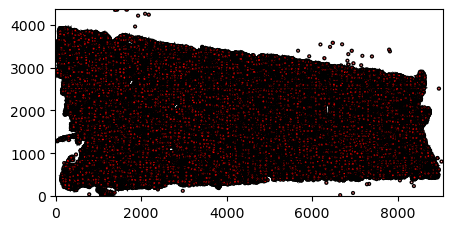

In [25]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 5))

for row_cell, row_nuclei in tqdm.tqdm(zip(cell_vertices[:], nuclei_vertices[:])):
    cell_x_coords = row_cell[::2]
    cell_y_coords = row_cell[1::2]
    cell_points = np.column_stack((cell_x_coords, cell_y_coords))
    
    nuclei_x_coords = row_nuclei[::2]
    nuclei_y_coords = row_nuclei[1::2]
    nuclei_points = np.column_stack((nuclei_x_coords, nuclei_y_coords))

    # Create and add polygon
    cell_polygon = Polygon(cell_points, closed=True, fill=False, edgecolor='black', linewidth=2)
    nuclei_polygon = Polygon(nuclei_points, closed=True, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(cell_polygon)
    ax.add_patch(nuclei_polygon)
    # Set axis limits based on the actual coordinate ranges
min_x, max_x = np.min(cell_vertices[:, ::2]), np.max(cell_vertices[:, ::2])
min_y, max_y = np.min(cell_vertices[:, 1::2]), np.max(cell_vertices[:, 1::2])
ax.set_xlim(min_x - 10, max_x + 10)
ax.set_ylim(min_y - 10, max_y + 10)
# Set equal aspect ratio and show plot
ax.set_aspect('equal')
plt.show()

In [36]:
cell_feature_matrix.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='cell_features', nodes=(Node(disable…

In [43]:
cell_feature_matrix['cell_features/cell_id'][:]

array([[     24201,          1],
       [     40234,          1],
       [    128854,          1],
       ...,
       [3906232051,          1],
       [3906257334,          1],
       [3906261297,          1]], shape=(162628, 2), dtype=uint32)

In [60]:
def cell_id_format_mapping(prefix:int, suffix):
    # Step 0: Convert to hex and strip the '0x' prefix
    hex_str = hex(prefix)[2:]
    
    # Step 1: Pad to 8-digit hex string
    padded_hex = hex_str.zfill(8).lower()

    # Step 2: Create mapping from hex to shifted range
    hex_chars = '0123456789abcdef'
    shifted_chars = 'abcdefghijklmnop'
    hex_to_shifted = {h: s for h, s in zip(hex_chars, shifted_chars)}

    # Step 3: Apply character mapping
    shifted = ''.join(hex_to_shifted[char] for char in padded_hex)
    
    # Step 4: Append dataset_suffix
    return shifted + f'-{suffix}'

# Example
cell_id_prefix = 1437536272
suffix = 1
result = cell_id_format_mapping(cell_id_prefix, suffix)
print(result)  # Output: aaedfbbi


ffkpbaba-1


In [61]:
cell_id_new_format = [cell_id_format_mapping(prefix, suffix) for prefix, suffix in zip(cell_feature_matrix['cell_features/cell_id'][:][:, 0], cell_feature_matrix['cell_features/cell_id'][:][:, 1])]

In [75]:
index = np.where(np.array(cell_id_new_format) == 'hommpihc-1')[0][0]
index

np.int64(88381)

In [71]:
cells.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='cell_id (162628, 2) u…

In [76]:
cells['cell_summary'][:][index]

array([ 110.19068146, 3931.15307617,  511.93642483,  110.45381927,
       3923.85131836,   35.9443763 ,   15.        ])

In [89]:
cell_feature_matrix.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='cell_features', nodes=(Node(disable…

In [90]:
cell_feature_matrix['cell_features/cell_id'][:]

array([[     24201,          1],
       [     40234,          1],
       [    128854,          1],
       ...,
       [3906232051,          1],
       [3906257334,          1],
       [3906261297,          1]], shape=(162628, 2), dtype=uint32)

In [104]:
indices = analysis['cell_groups/0/indices'][:]
indices

array([    17,     19,     20, ..., 162396,      0,      0],
      shape=(162628,), dtype=uint32)

In [102]:
indptr = analysis['cell_groups/0/indptr'][:]
indptr

array([     0,  27686,  53171,  69371,  83923,  97414, 108144, 116645,
       123997, 129473, 134613, 138989, 143152, 146935, 150614, 153958,
       157087, 159939], dtype=uint32)

In [113]:
indices[index]

np.uint32(61366)

In [118]:
cell_feature_matrix['cell_features/data'][:]

array([ 1,  1,  1, ..., 69, 49, 20], shape=(9934340,), dtype=uint32)

In [119]:
cell_feature_matrix['cell_features/indptr'][:]

array([      0,     433,    1656,    2810,   40297,   77179,  158429,
        166473,  192515,  194297,  212640,  238483,  251582,  252175,
        253157,  254114,  254733,  278679,  328560,  329494,  333386,
        340802,  349232,  354699,  410230,  416764,  421174,  437926,
        440541,  454549,  454918,  459002,  460213,  480905,  489355,
        494436,  562148,  562402,  563784,  600788,  707527,  763653,
        808957,  833185,  836208,  858876,  859525,  885482,  907215,
        909355, 1030057, 1034172, 1035629, 1168003, 1186565, 1187229,
       1187363, 1190291, 1193548, 1212460, 1215990, 1216269, 1281633,
       1352732, 1354566, 1453272, 1460777, 1500783, 1516288, 1518358,
       1518682, 1522458, 1522714, 1538412, 1546823, 1550405, 1553632,
       1587217, 1599669, 1600795, 1601797, 1604925, 1608151, 1619672,
       1625330, 1628324, 1629406, 1638059, 1641332, 1654455, 1660842,
       1674163, 1694582, 1703784, 1722086, 1728528, 1728755, 1731308,
       1741776, 1750

In [129]:
import scipy.sparse as sparse

In [123]:
data = cell_feature_matrix['cell_features/data'][:]
indices = cell_feature_matrix['cell_features/indices'][:]
indptr = cell_feature_matrix['cell_features/indptr'][:]

In [126]:
n_rows = len(indices) - 1

In [136]:
len(indptr)

540

In [138]:
len(data)

9934340

In [139]:
len(indices)

9934340

In [140]:
len(indptr)

540

In [142]:
feature_by_cell = sparse.csr_matrix((data, indices, indptr), shape = (539, 162628))

In [143]:
cell_by_feature = feature_by_cell.T

In [167]:
features = cell_by_feature.getrow(61366).toarray().flatten()
features

array([  0,   0,   0,   1,   0,   1,   0,   1,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   1,   0,   0,
         2,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,
         4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         6,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   3,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   3,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   3,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   2,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   3,   0,   0,   0,   0,   1,   1,   0,   0,   0,   1,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [170]:
features[:-1].sum()

np.uint64(119)

In [150]:
import json

In [154]:
with open('cell_feature_matrix.zarr/cell_features/.zattrs', 'r') as f:
    zattrs = json.load(f)

In [156]:
zattrs.keys()

dict_keys(['feature_ids', 'feature_keys', 'feature_types', 'major_version', 'minor_version', 'number_cells', 'number_features'])

In [164]:
# Filter keys where type is 'gene'
gene_keys = [key for key, ftype in zip(zattrs['feature_keys'], zattrs['feature_types']) if ftype == 'gene']

In [166]:
len(gene_keys)

474

In [171]:
gene_indices = [i for i, ftype in enumerate(zattrs['feature_types']) if ftype == 'gene']

In [176]:
features[gene_indices].sum()

np.uint64(119)